# Item based collaborative filtering

In [26]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import scipy.stats
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
ratings = pd.read_csv('~/Codes/Clustering/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [28]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [29]:
print('unique users -', ratings.userId.nunique())
print('unique movies -', ratings.movieId.nunique())
print('unique ratings -', ratings.rating.nunique())
print('unique ratings list -', sorted(ratings.rating.unique()))

unique users - 610
unique movies - 9724
unique ratings - 10
unique ratings list - [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [30]:
movies = pd.read_csv('~/Codes/Clustering/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
df = pd.merge(ratings, movies, on='movieId', how='inner')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [32]:
aggregate_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                number_of_ratings = ('rating', 'count')).reset_index()

# Aggregate ratings with over 100 ratings
aggregate_ratings_over_100 =aggregate_ratings[aggregate_ratings.number_of_ratings > 100]

aggregate_ratings_over_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


In [33]:
# Checking popular movies
aggregate_ratings_over_100.sort_values(by = 'number_of_ratings', 
                                    ascending = False).head()

,title,mean_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


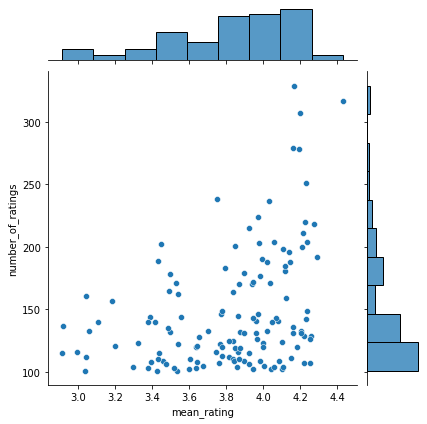

In [34]:
sns.jointplot(x = 'mean_rating', y = 'number_of_ratings', 
                data = aggregate_ratings_over_100)

In [35]:
df_over_100 = pd.merge(df, aggregate_ratings_over_100[['title']],
                        on = 'title', how = 'inner')
df_over_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19788 entries, 0 to 19787
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   movieId    19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
 4   title      19788 non-null  object 
 5   genres     19788 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


In [36]:
print('unique users -', df_over_100.userId.nunique())
print('unique movies -', df_over_100.movieId.nunique())
print('unique ratings -', df_over_100.rating.nunique())
print('unique ratings list -', sorted(df_over_100.rating.unique()))

unique users - 597
unique movies - 134
unique ratings - 10
unique ratings list - [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [37]:
matrix = df_over_100.pivot_table(index = 'title', columns = 'userId',
                                values = 'rating')
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,5.0,NaN,3.0,NaN,4.5
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,2.0,NaN,NaN,NaN,3.5,NaN,3.0
Aladdin (1992),NaN,NaN,NaN,4.0,4.0,5.0,3.0,NaN,NaN,4.0,...,NaN,NaN,NaN,3.0,3.5,NaN,NaN,3.0,NaN,NaN
Alien (1979),4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,4.0,3.0,4.0,NaN,4.5
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,3.5,NaN,4.5,NaN,5.0


In [38]:
# normalizing the matrix
matrix_normalized = matrix.subtract(matrix.mean(axis = 1), axis = 0)
matrix_normalized.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,0.105505,NaN,NaN,NaN,...,NaN,NaN,1.105505,NaN,NaN,1.105505,NaN,-0.894495,NaN,0.605505
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,-0.040373,-0.040373,NaN,NaN,NaN,NaN,...,NaN,-1.040373,NaN,-1.040373,NaN,NaN,NaN,0.459627,NaN,-0.040373
Aladdin (1992),NaN,NaN,NaN,0.20765,0.207650,1.207650,-0.792350,NaN,NaN,0.20765,...,NaN,NaN,NaN,-0.792350,-0.29235,NaN,NaN,-0.792350,NaN,NaN
Alien (1979),0.030822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.030822,NaN,NaN,0.030822,-0.969178,0.030822,NaN,0.530822
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.035714,NaN,NaN,-0.464286,NaN,0.535714,NaN,1.035714


In [39]:
# item similarity matrix using Pearson Correlation
item_similarity = matrix_normalized.corr()
item_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.277751,-0.102773,-0.229897,-0.404880,0.428244,0.993607,0.081504,...,-0.152963,0.044828,-0.066331,-0.348104,0.779927,0.027001,-0.125513,0.034010,0.233941,-0.008664
2,NaN,1.0,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,...,-0.064510,NaN,-1.000000,NaN,NaN,0.740608,NaN,0.480247,NaN,0.843616
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.277751,NaN,NaN,1.000000,-0.460588,0.394466,0.512145,0.030367,NaN,0.463879,...,-0.269760,0.474911,0.077807,-0.262337,0.918918,-0.127439,-0.107429,-0.460654,1.000000,-0.286740
5,-0.102773,NaN,NaN,-0.460588,1.000000,-0.001558,0.161232,-0.267837,NaN,-0.815194,...,0.060226,0.016829,-0.104062,-0.201030,-0.130248,0.270744,0.005359,0.018492,0.346950,-0.065387


In [40]:
# Item similarity matrix using cosine similarity
item_similarity_cosine = cosine_similarity(matrix_normalized.fillna(0))
item_similarity_cosine

array([[ 1.        , -0.00896029,  0.01415581, ..., -0.08543583,
         0.0387289 , -0.05929884],
       [-0.00896029,  1.        ,  0.18349799, ...,  0.09401611,
         0.01525033,  0.01682738],
       [ 0.01415581,  0.18349799,  1.        , ...,  0.03938066,
         0.06071451,  0.08986864],
       ...,
       [-0.08543583,  0.09401611,  0.03938066, ...,  1.        ,
         0.03348121,  0.02301284],
       [ 0.0387289 ,  0.01525033,  0.06071451, ...,  0.03348121,
         1.        ,  0.035578  ],
       [-0.05929884,  0.01682738,  0.08986864, ...,  0.02301284,
         0.035578  ,  1.        ]])

# Predict user's rating for one movie

In [41]:
picked_userId = 1
picked_movie = 'American Pie (1999)'
picked_userId_watched = pd.DataFrame(matrix_normalized[picked_userId].dropna(axis = 0, how = 'all')\
                            .sort_values(ascending = False))\
                            .reset_index()\
                            .rename(columns = {1 : 'rating'})
picked_userId_watched.head()

,title,rating
0,Dumb & Dumber (Dumb and Dumber) (1994),1.939850
1,Indiana Jones and the Temple of Doom (1984),1.361111
2,X-Men (2000),1.300752
3,E.T. the Extra-Terrestrial (1982),1.233607
4,Ghostbusters (a.k.a. Ghost Busters) (1984),1.225000


In [45]:
# Similarity score of the movie American Pie with all the other movies
picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={'American Pie (1999)':'similarity_score'})
# Rank the similarities between the movies user 1 rated and American Pie.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userId_watched, 
                                            right=picked_movie_similarity_score, 
                                            on='title', 
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]
# Take a look at the User 1 watched movies with highest similarity
picked_userid_watched_similarity

KeyError: "None of [Index(['American Pie (1999)'], dtype='object', name='userId')] are in the [columns]"

In [43]:
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
weights = picked_userid_watched_similarity['similarity_score']), 6)

NameError: name 'picked_userid_watched_similarity' is not defined